# **Text mining problem description**

For my project, I am attempting to train a spacy NER model to recognize miRNA as a named entity. Although finding miRNA within a document is something that could possibly be done with regex matching, spacy offers many features in the NLP pipeline regarding named entities, and in order to utilize these features with a named entity, it must be able to be recognized by spacy, which cannot be done with regex matching (example below). 

![](https://nlpforhackers.io/wp-content/uploads/2018/03/Screen-Shot-2018-03-28-at-12.09.32.png)

Ideally, the miRNA entity would be added to an existing model, such as `scispacy`. By updating `scispacy`'s `en_ner_bionlp13cg_md` model which has a NER for things like `GENE_OR_GENE_PRODUCT`, `ORGANISM`, `PATHOLOGICAL_FORMATION`, and more, we could theoretically obtain the relationship between miRNA and these entities, which could be used on a larger scale to potentially identify genes within literature that may be associated with a given miR to uncover regulatory networks and other associations. 

For the purpose of this assignment, we will not be updating an existing model (due to time constraints), but we will run through the process of trianing a model, and at the end identify other potential improvements for this pipeline that would ultimately provide high level, practical performance.

# 2) **Dataset Description**

To train a NER model in spacy, we need to know the start and end index of the string of interest. Seeing as there is no annotated data in the wild where this exists for miRNA, we will have to make some. We will do this by:

- 1) Fetching miR abstracts from pubmed
- 2) Cleaning the abstracts and sentence tokenizing
- 3) Using Regex to find miRNA and their position in the string
- 4) Format the data to be used by spacy

### 2.1) Install Dependencies

Note, for this exercise, we need to used `spacy 2.2.2`. We will ensure that this is the correct version imported below:

In [ ]:
!pip install xlrd
!pip uninstall spacy
!pip install spacy==2.2.2

Uninstalling spacy-2.2.4:
  Would remove:
    /usr/local/bin/spacy
    /usr/local/lib/python3.7/dist-packages/bin/*
    /usr/local/lib/python3.7/dist-packages/spacy-2.2.4.dist-info/*
    /usr/local/lib/python3.7/dist-packages/spacy/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/bin/theano_cache.py
    /usr/local/lib/python3.7/dist-packages/bin/theano_nose.py
Proceed (y/n)? y
  Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 10.3MB 5.1MB/s 
     |████████████████████████████████| 2.2MB 51.2MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0


In [ ]:
import urllib.request
import io
import gzip
import os
from pathlib import Path
import pandas as pd
try:
    from Bio import Entrez
except ModuleNotFoundError:
    !pip install Bio
    from Bio import Entrez
import re
import random
import spacy

     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 2.3MB 6.5MB/s 


### 2.2) Creating a database of known miRs and accessions numbers to query literature

To standardize things, we will make a key between miR names and accessions numbers. We will submit accession numbers into python, which will be handlesd by this database to get the corresponding miR, which will be used to query pubmed.

In [ ]:
response = urllib.request.urlopen('ftp://mirbase.org/pub/mirbase/CURRENT/miRNA.xls.gz')
compressed_file = io.BytesIO(response.read())
decompressed_file = gzip.GzipFile(fileobj=compressed_file)

with open(Path(os.getcwd(), 'miRNA.xlsx'), 'wb') as outfile:
    outfile.write(decompressed_file.read())

mir_database = pd.read_excel('miRNA.xlsx')

mir_database_1 = mir_database.loc[:, ['Accession', 'ID']]
mir_database_2 = mir_database.loc[:, ['Mature1_Acc', 'Mature1_ID']].rename(columns = {'Mature1_Acc':'Accession', 'Mature1_ID':'ID'})
mir_database_3 = mir_database.loc[:, ['Mature2_Acc', 'Mature2_ID']].rename(columns = {'Mature2_Acc':'Accession', 'Mature2_ID':'ID'})

final_database = pd.concat([mir_database_1, mir_database_2, mir_database_3])

final_database.head()

,Accession,ID
0,MI0000001,cel-let-7
1,MI0000002,cel-lin-4
2,MI0000003,cel-mir-1
3,MI0000004,cel-mir-2
4,MI0000005,cel-mir-34


### 2.3) Define functions 

To 1) fetch abstracts from pubmed, and 2) clean the abstracts and standardize their format, and finally 3) query pubmed and clean the abstract using functions 1 & 2. 

In [ ]:
# Function 1

def fetch_abstract(pmid):
    handle = Entrez.efetch(db='pubmed', id = pmid, retmode='xml')
    article = Entrez.read(handle)['PubmedArticle'][0]['MedlineCitation']['Article']
    if 'Abstract' in article:
            return article['Abstract']['AbstractText']
        
# Function 2

def concat_article(x):
    final_article = str()
    for i in range(len(x)):
        final_article = final_article + str(x[i]) + ' '
    return final_article

# Function 3

def get_literature(user_mir):
    
    filtered_database = final_database[final_database['Accession']  == user_mir]['ID']
    filtered_database = final_database[final_database['Accession']  == user_mir]['ID']

    if filtered_database.size == 1:
        mir = filtered_database.iloc[0]
        print('The accession number ' + user_mir + ' corresponds to miR ' + mir)
    else:
        print('miR accession is incorrect. Try again (caps sensitive)')

    Entrez.email = 'anonymous@gmail.com'
    esearch_query = Entrez.esearch(db="pubmed", term="mir-100", retmode="xml")
    esearch_result = Entrez.read(esearch_query)
    pmid_list = esearch_result['IdList']
    print("pmid's obtained: " + str(len(pmid_list)))
    
    abs_list = []

    for i in pmid_list:
        abs = fetch_abstract(i)
        abs_list.append(abs)
        
    abs_list = [concat_article(i) for i in abs_list if i is not None]
    
    return(abs_list)

### 2.4) Fetching Abstracts

Now, we will maually enter the accession number of 10 miRNA to use to get literature on using our functions.

In [ ]:
training_mir = ['MI0000692', 'MI0000159', 'MI0000172', 'MI0000406', 'MI0000111', 'MI0000684', 'MI0000256', 'MI0000170', 'MI0000268', 'MI0002470']

Getting literature:

In [ ]:
all_abstracts = []

for i in training_mir:
    abstracts = get_literature(i)
    all_abstracts = all_abstracts + abstracts

The accession number MI0000692 corresponds to miR mmu-mir-100
pmid's obtained: 20
The accession number MI0000159 corresponds to miR mmu-mir-133a-1
pmid's obtained: 20
The accession number MI0000172 corresponds to miR mmu-mir-150
pmid's obtained: 20
The accession number MI0000406 corresponds to miR mmu-mir-106a
pmid's obtained: 20
The accession number MI0000111 corresponds to miR hsa-mir-105-1
pmid's obtained: 20
The accession number MI0000684 corresponds to miR mmu-mir-107
pmid's obtained: 20
The accession number MI0000256 corresponds to miR mmu-mir-122
pmid's obtained: 20
The accession number MI0000170 corresponds to miR mmu-mir-146a
pmid's obtained: 20
The accession number MI0000268 corresponds to miR hsa-mir-34a
pmid's obtained: 20
The accession number MI0002470 corresponds to miR hsa-mir-486-1
pmid's obtained: 20


# 3) **Text Processing**

### 3.1) Sentence Tokenization

We will split all the abstracts into sentence tokens, seeing as this is standard practice when creating a spacy NER, and recommended in their documentation.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
nltk.download('punkt')

all_sentences = []

for mir_abs in all_abstracts:
    abstr_sentences = sent_tokenize(mir_abs)
    all_sentences = all_sentences + abstr_sentences


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### 3.2) Making training and testing data

From our sentences, we will first randomly shuffle them:

In [ ]:
random.shuffle(all_sentences)

And then we will allocate 80% for training, and 20% for testing:

In [ ]:
training_sentences = all_sentences[0:int(.8 * len(all_sentences))]
testing_sentences = all_sentences[int(.8 * len(all_sentences)):len(all_sentences)]

### 3.3) Labelling the training data

Now, we will use a regex to find miRNA occurances in a sentence. For each occurance we find, we will also locate the string index that corresponds to the start and end of the string, which is required by spacy.

In [ ]:
def make_training_data(string):
    if len([i for i in re.finditer('mir-\d+[^\s|.|,|!|?| |:|;]*', string.lower())]) != 0:
        ent_list = []
        for i in re.finditer('mir-\d+[^\s|.|,|!|?| |:|;]*', string.lower()):
            ent_code = (i.start(), i.end(), 'miR')
            ent_list.append(ent_code)
            
    else:
        ent_list = []      
    return((string, {'entities' : ent_list}))    

In [ ]:
training_data = [make_training_data(i) for i in training_sentences]

An example of the format of the input data:

In [ ]:
training_data[0:3]

[('Moreover, 1381 potential target genes were predicted using the prediction database tool, miRNet.',
  {'entities': []}),
 ('Furthermore, our findings indicate that the sEV miR-100-5p promotes angiogenesis during the implantation process.',
  {'entities': [(48, 58, 'miR')]}),
 ('For this purpose, MCF-7 and MDA-MB-435\xa0cells were seeded different number in E-plate 16 for proliferation experiment using an electrical impedance-based real-time cell analyzer system (RTCA) for 168\xa0h. Similarly, invasion potential of MCF-7 and MDA-MB-435 were determined by RTCA for 90\xa0h. Total RNAs including miRNAs were isolated at 2, 4, 6, 12, 24, 48\xa0h from the MCF-7 and MDA-MB-435\xa0cells.',
  {'entities': []})]

### 3.4) Data Exploration

Just to get a feel for our data, we will explore various aspects:
- Number of miR labels per sentence
- Sentence length
- Term Frequency

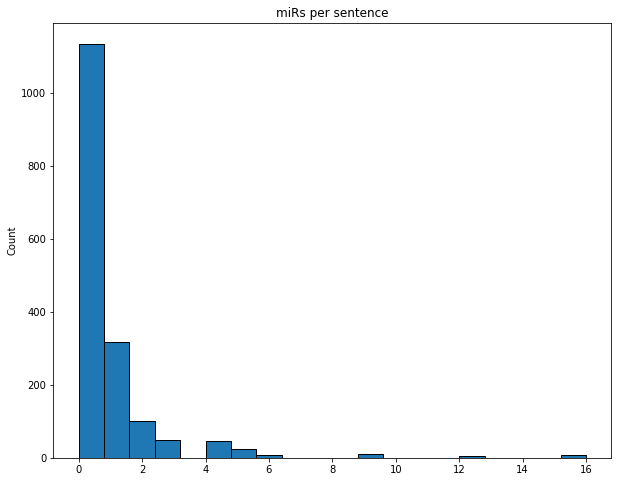

In [ ]:
# Number of miRs per sentence

import matplotlib.pyplot as plt

mir_length = [len(training_data[i][1]['entities']) for i in range(len(training_data))]

plt.figure(figsize=[10,8])
plt.hist(mir_length, bins = 20, edgecolor = 'black')
plt.title('miRs per sentence')
plt.ylabel('Frequency')
plt.ylabel('Count')
plt.show()

As we can see, most sentences have either 0 or 1 miR label. 

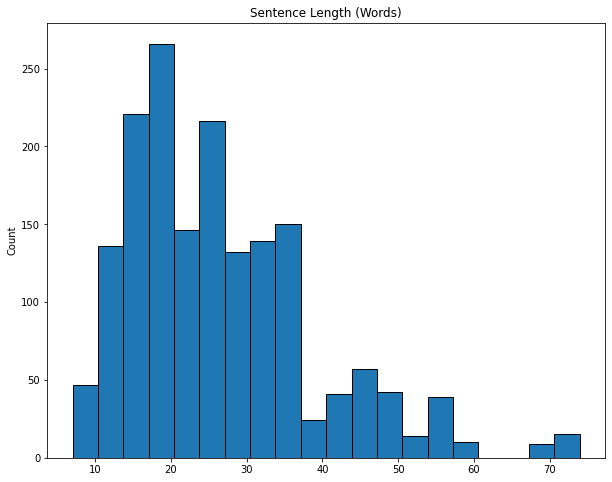

In [ ]:
# Average sentence length

import matplotlib.pyplot as plt

mir_length = [len(word_tokenize(training_data[i][0])) for i in range(len(training_data))]

plt.figure(figsize=[10,8])
plt.hist(mir_length, edgecolor = 'black', bins = 20)
plt.title('Sentence Length (Words)')
plt.ylabel('Frequency')
plt.ylabel('Count')
plt.show()


Most sentences are under 40 words.

Finally, we will make a word cloud using term frequency. First, we will word tokenize all of our words and use a term frequency encoder for feature representation, removing common stopwords that may be unhelpful:

In [ ]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
punctuation = '.,?:;()"' + "'"

sentence_glob = ' '.join(all_sentences)
tokenized = word_tokenize(sentence_glob)

abs_vect = CountVectorizer(stop_words = stopwords.words('english'))
abs_bow = abs_vect.fit_transform(tokenized)
word_freq_df = pd.DataFrame(abs_bow.toarray(), columns = abs_vect.get_feature_names())
word_freq_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,001,002,003,01,05,10,100,10a,10b,11,1172,12,122,1246,125a,125b,127,1273g,130a,1381,139,141,142,145,146b,15,150,15a,16,168,18,182,183,19,192,194,195,199a,1β,20,...,upregulated,upregulation,use,used,using,uterus,utr,v8,validated,value,variable,variation,various,vat,vehicle,vein,verified,vesicles,via,viability,viewer,virus,visceral,vitro,vm,vs,ways,well,western,whereas,whether,whr,window,wnt,woi,women,worldwide,years,yet,zebrafish
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We can then manually look at the most frequent terms in our bag of words:

In [ ]:
from collections import Counter

freq_sum_list = []
for i in word_freq_df.columns:
    freq_sum_list.append(word_freq_df[i].sum())
freq_counter = Counter(dict(zip(word_freq_df.columns, freq_sum_list)))
freq_counter.most_common(15)

[('mir', 1640),
 ('100', 640),
 ('5p', 600),
 ('expression', 510),
 ('sub', 480),
 ('mirnas', 450),
 ('cell', 360),
 ('mirna', 320),
 ('cancer', 270),
 ('analysis', 230),
 ('cells', 220),
 ('study', 220),
 ('human', 210),
 ('using', 210),
 ('3p', 200)]

And finally, plot this as a wordcloud for visualization:

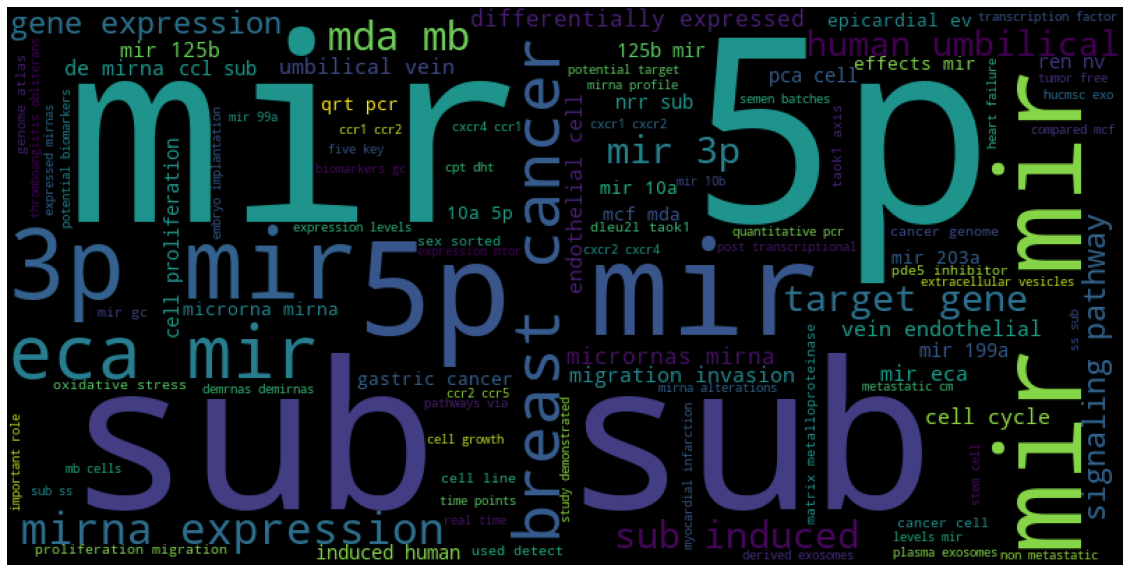

In [ ]:
from wordcloud import WordCloud

wordcloud_list = [i.lower() for i in tokenized if i not in stopwords.words('english') and i not in punctuation]

unique_string=(" ").join(wordcloud_list)
wordcloud = WordCloud(max_words=100, width=800, height=400).generate(unique_string)
plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 4) **Text Representation**

Seeing as no direct feature representation needs to be done by the user to train a SpaCy model, I will explain what feature representation occurs behind the scenes in SpaCy's NLP pipeline when a NER model is trained. Fundamentally, SpaCy's model uses word embedding to represent the text, and then uses a 1D CNN framework to predict entities. Both of these components will be explained below:

### 4.1) Word Embedding

Word Embedding is based on the principle that similar words will appear in similar contexts. In the classic example of cat and dog, the words "cat" and "dog" will be more similar to each other that the words "dog" and "hotdog". This is because there will be much more overlap in the words around cat and dog (vet, furry, pet, animal, etc.) than between the words "dog" and "hotdog". 

Using this principle, each word in a sentence is assigned a word embedding, which turns each word into a numeric integer vector where we can apply distance metrics to see which words are most similar. 

### 4.2) 1D CNN

Once each word has been embedded and the document (sentence) forms a matrix when all words are included, this numeric text representation is fed into a 1D CNN. In a 1D CNN, the kernel filter moves in only one direction (shown below), an essentially gives an output summary that allows us to numerically represent the word in question, along with the words adjacent to it. 

![](https://miro.medium.com/max/700/0*iapmXxH2jwdIhvMX.gif)

This will ultimately yield an output which, when compared to the correct label (named entity), will be used to adjust the network weights. Using gradient descent, the weights will be adjusted to minimize a loss function, which can be optimized by increasing the number of epochs as well as setting hyper-parameters.

# 5) **Text Models**

### 5.1) Training the model

Now, we will train a new NER model in spacy to be able to recognize miRNA. To do this, we will initialize a blank model, and turn on only the NER component so that we do not train other components such as the POS tagger.

We will also use a dropout of .2 to prevent overfitting, and return the losses as the model trains to monitor progress.

In [ ]:
!pip install spacy-lookups-data

     |████████████████████████████████| 93.4MB 45kB/s 


In [ ]:
def train_spacy(data,iterations):
    TRAIN_DATA = data
    nlp = spacy.blank('en')  # create blank Language class
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
       

    # add labels
    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            print("Starting iteration " + str(itn))
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                nlp.update(
                    [text],  # batch of texts
                    [annotations],  # batch of annotations
                    drop=0.2,  # dropout - make it harder to memorise data
                    sgd=optimizer,  # callable to update weights
                    losses=losses)
            print(losses)
    return nlp

Now, we will train the model with 10 epochs; which was the point at which I noticed diminishing returns in the model's loss:

In [ ]:
miRnlp = train_spacy(training_data, 10)

Starting iteration 0
{'ner': 810.6574003546915}
Starting iteration 1
{'ner': 328.73741447715895}
Starting iteration 2
{'ner': 82.70778338574661}
Starting iteration 3
{'ner': 153.8477037217474}
Starting iteration 4
{'ner': 91.77078286108066}
Starting iteration 5
{'ner': 26.901814338174727}
Starting iteration 6
{'ner': 1.4744058911775026}
Starting iteration 7
{'ner': 2.9679870744539505}
Starting iteration 8
{'ner': 298.94076598651685}
Starting iteration 9
{'ner': 37.3206816168492}


# 6) **Evaluations**

To evaluate the performance of our model, we will compare our model's performance on our allocated testing data vs. the existing labels we generated with regexp matching. Let's first compare the NER output from our model vs. that of the regexp matching we did earlier.

In [ ]:
# Example model output
for i in testing_sentences[0:10]:
    print(i)
    doc = miRnlp(i)
    print("Entities", [(ent.start_char, ent.end_char, ent.text, ent.label_) for ent in doc.ents])
    print()

Moreover, CCND1 was shown to be a novel target gene of miR-194 in GC.
Entities [(55, 62, 'miR-194', 'miR')]

Here, ReNcell VM (ReN) cells, a neural progenitor cell line was serially extruded to produce NV.
Entities []

Thus, these 28 miRNAs can serve as prospective biomarkers for the diagnosis of breast cancer.
Entities []

Administration of exosomes from negative scramble miRNA (NC)-transfected hucMSCs blocked H/R-caused lactate dehydrogenase release, pyroptosis, and over-regulation of NLRP3 and activated caspase-1(p20) and GSDMD-N as well as release of IL-1β and IL-18.
Entities []

Further investigations will be necessary to confirm these findings, contributing to the elucidation of new therapeutic targets in patients who do not respond to CPAP treatment.
Entities []

HepG2 and HT-29 cells were treated with DHT or CPT for 72 h. MiRNA, transcription factor encoding mRNA, and downstream gene expression were determined using real-time quantitative PCR.
Entities []

Protein expression wa

In [ ]:
# Example regexp output
[make_training_data(i) for i in testing_sentences[0:10]]

[('Moreover, CCND1 was shown to be a novel target gene of miR-194 in GC.',
  {'entities': [(55, 62, 'miR')]}),
 ('Here, ReNcell VM (ReN) cells, a neural progenitor cell line was serially extruded to produce NV.',
  {'entities': []}),
 ('Thus, these 28 miRNAs can serve as prospective biomarkers for the diagnosis of breast cancer.',
  {'entities': []}),
 ('Administration of exosomes from negative scramble miRNA (NC)-transfected hucMSCs blocked H/R-caused lactate dehydrogenase release, pyroptosis, and over-regulation of NLRP3 and activated caspase-1(p20) and GSDMD-N as well as release of IL-1β and IL-18.',
  {'entities': []}),
 ('Further investigations will be necessary to confirm these findings, contributing to the elucidation of new therapeutic targets in patients who do not respond to CPAP treatment.',
  {'entities': []}),
 ('HepG2 and HT-29 cells were treated with DHT or CPT for 72 h. MiRNA, transcription factor encoding mRNA, and downstream gene expression were determined using real-

So far, so good. To quantify the accuracy of our model, we will use an F1 score which describes the relationship between precision and recall (shown below).

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)

![](https://miro.medium.com/max/1530/1*wUdjcIb9J9Bq6f2GvX1jSA.png)



To get this score, we will need to calculate the following for each prediction the model makes:

- **True positives** (how many entities the model predicted that are in the gold standard data)
- **False positives** (how many entities the model predicted that are NOT in the gold standard data)
- **False Negatives** (how many entities that were in the gold standard data that were NOT predicted)

To get these numbers, we will need to build some functions that we will use to iterate through both the predicted entities and true entities.

First, we will make a function that only returns the entity position and label as a string, formatted at `start_stop_entity`. For each prediction, we will convert all detected entities into this format to make comparing the lists easier.

In [ ]:
def get_model_ents(sent):
  doc = miRnlp(sent)
  ent_list = []
  for ent in doc.ents:
    ent_code = str(ent.start_char) + '_' + str(ent.end_char) + '_' + str(ent.label_)
    ent_list.append(ent_code)

  return(ent_list)

An example of the output:

In [ ]:
[get_model_ents(i) for i in testing_sentences[0:10]]

[['55_62_miR'], [], [], [], [], [], [], [], [], ['59_69_miR']]

In [ ]:
all_ent_predictions = [get_model_ents(i) for i in testing_sentences]

Now, we will make the same function, but for use on our gold standard data to compare the two.

In [ ]:
def check_testing_data(string):
    if len([i for i in re.finditer('mir-\d+[^\s|.|,|!|?| |:|;]*', string.lower())]) != 0:
        ent_list = []
        for i in re.finditer('mir-\d+[^\s|.|,|!|?| |:|;]*', string.lower()):
            ent_code = str(i.start()) + '_' + str(i.end()) + '_' + 'miR'
            ent_list.append(ent_code)
            
    else:
        ent_list = []      
    return(ent_list)  

In [ ]:
[check_testing_data(i) for i in testing_sentences[0:10]]

[['55_62_miR'], [], [], [], [], [], [], [], [], ['59_69_miR']]

In [ ]:
all_correct_labs = [check_testing_data(i) for i in testing_sentences]

Finally, we can iterate through both lists and compute `true_positive`, `false_positive`, and `false_negative` using the rules we mentioned earlier.

In [ ]:
true_positive = 0
false_positive = 0
false_negative = 0

for entry in range(len(all_correct_labs)):

  for pred_label in range(len(all_ent_predictions[entry])):
    true_positive += all_ent_predictions[entry][pred_label] in all_correct_labs[entry]
    false_positive += all_ent_predictions[entry][pred_label] not in all_correct_labs[entry]
  
  for true_label in range(len(all_correct_labs[entry])):
    false_negative += all_correct_labs[entry][pred_label] not in all_ent_predictions[entry]

In [ ]:
miR_precision = true_positive / (true_positive + false_positive)
miR_recall = true_positive / (true_positive + false_negative)

print("True Positive: " + str(true_positive))
print("False Positive: " + str(false_positive))
print("False Negative: " + str(false_negative))
print("Precision: " + str(miR_precision))
print("Recall: " + str(miR_recall))

True Positive: 326
False Positive: 0
False Negative: 0
Precision: 1.0
Recall: 1.0


Finally, we can compute F1 score below.

In [ ]:
miR_f1 = 2 * ((miR_precision * miR_recall) / (miR_precision + miR_recall))

print("F1 Score: " + str(miR_f1))

F1 Score: 1.0


As we can see, our model performs perfectly *relative to our regexp matching*. This, however, does not mean that it is perfect, and will be discussed below. 

# 7) **Observations**

### 7.1) What I learned from this project

Working on mainly bioinformatics in lab, this project was inspired by a curiosity that arose whenever various bioinformatics tools would group several genes/gene products together because they had been mentioned together in literature. I was especially intrigued by software that would tell me that gene X is known to regulate gene Y, which was a conclusion it had come to via text mining. I wanted to understand how a computer could learn this association by machine learning.

When I came across SpaCy in my datacamp tutorials, I began to understand how these associations could be formed using NER's, POS tagging, and word dependency via sentence structure. Having to do this in SpaCy meant that any entity you are interested in (a gene or miRNA) had to be recognized by SpaCy's models as the entitiy in question. If the entity is not recognized by SpaCy, however (in the case of miRNA), a model would have to be trained and updated so that spacy could use it going forward in its NLP pipeline. To attempt to do this, I successfully trained a NER model to recognize rudimentary miRNA occurances in text.

Apart from learning how to operate the spacy pipeline, I also learned a lot about sentence similarity, word cloud generation, and other things that are commonly used in bioinformatics (for example, the simplification of GO terms). I also learned fundamentally how these bioinformatics tools can make gene associations just by text mining, and completed the first step in this presumably long process.

### 7.2) Strengths and limitations of Text Mining pipeline

Although this pipeline has a seemingly perfect F1 score, the model itself is not very robust and is limited by the training data that was fed to it. It is unabel to recognize miRNA entities that are not in the `miR-XXX` format, seeing as no training data was fed to it that was outside of this format. An example of a miRNA entity that SpaCy would miss is in the example sentence below:

In [ ]:
example_sent = "This is an example about microRNA 122."

doc = miRnlp(example_sent)
print("Entities", [(ent.start_char, ent.end_char, ent.text, ent.label_) for ent in doc.ents])

Entities []


Clearly, `microRNA 122`  should be a miR entity, however since the model saw no training data in this format, it is not detected. 

In addition to the model's limited ability to recognize diverse miRNA formats, it is also unable to *do anything* with the named entity other than identify it. This is because we created a new model from scratch, as opposed to building on an existing one. The process for adding onto a new model, however, is essetially the same pipeline as what was done here, and many of the code used in this notebook could easily be converted to build onto an existing model.

### 7.3) Improvements to pipeline

Several improvements could be made to improve our model. These are described below:

- More diversity in training data, allowing for a more robust NER that can find miRNA entities that fall outside of the `miR-XXX` format
- Building on an existing SciSpaCy model so that we can identify word relationships and dependencies, further emulating bioinformatic text mining tools
- Hyper-Parameter tuning of model: try various combinations of epochs, dropout, etc. (however this version of SpaCy seems to be [notorious for poorly documenting hyperparameter tuning procedures](https://github.com/explosion/spaCy/issues/3352)).
- Write this code in SpaCy 3.X. Seeing as this code is only compadible for spacy 2.X, it would be good to update it to the latest code version for best results and future-proofing.

# 8) **Thanks for a Great Semester!**